# MISA Project Atlas final pipeline

## Students: Leonardo Pestana Legori, Lisle Faray de Paiva

## Imports and definitions

In [2]:
PROJECT_FOLDER = "D:\\Files\\Projects\\MAIA\\UdG\\MISA\\Project"
DATA_FOLDER = PROJECT_FOLDER + "\\dataset"

In [3]:
import SimpleITK as sitk
import os
import glob
import pandas as pd
import itertools
import numpy as np
import matplotlib.pyplot as plt

## Functions

In [4]:
def get_img_info(img):
    print(f"Image info:",
            f"\n\tSize: {img.GetSize()}",
            f"\n\tSpacing: {img.GetSpacing()}",
            f"\n\tOrigin: {img.GetOrigin()}",
            f"\n\tDirection: {img.GetDirection()}",
            f"\n\tPixel type: {img.GetPixelIDTypeAsString()}",)

In [5]:
def register_elastix(
    fixed_image,
    moving_image,
    parameters,
    output_dir,
    fixed_mask=None,
    moving_mask=None,
    verbose=False,
):
    """
    Register two images using elastix.

    Parameters
    ----------
    fixed_image (SimpleITK image): Fixed image.
    moving_image (SimpleITK image): Moving image.
    parameters (SimpleITK parameter map): Elastix parameter map.
    output_dir (str): Output directory.
    fixed_mask (SimpleITK image): Optional fixed mask.
    moving_mask (SimpleITK image): Optional moving mask.
    verbose (bool): Optional verbose output.

    Returns
    -------
    Tuple[SimpleITK image, SimpleITK parameter map] or None if fails.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # set up for registration
    elastix_image_filter = sitk.ElastixImageFilter()
    elastix_image_filter.SetFixedImage(fixed_image)
    elastix_image_filter.SetMovingImage(moving_image)
    if len(parameters) == 1:
        elastix_image_filter.SetParameterMap(parameters[0])
    else:
        elastix_image_filter.SetParameterMap(parameters[0])
        for parameter in parameters[1:]:
            elastix_image_filter.AddParameterMap(parameter)  
    elastix_image_filter.SetOutputDirectory(output_dir)
    elastix_image_filter.LogToConsoleOn()
    elastix_image_filter.LogToFileOn()
    elastix_image_filter.SetNumberOfThreads(8)
    
    # set up for optional components
    if fixed_mask:
        fixed_mask.CopyInformation(fixed_image)
        elastix_image_filter.SetFixedMask(fixed_mask)
    if moving_mask:
        moving_mask.CopyInformation(moving_image)
        elastix_image_filter.SetMovingMask(moving_mask)

    # perform registration
    try:
        elastix_image_filter.Execute()
    except RuntimeError as e:
        print(e)
        return None

    # get result
    result_image = elastix_image_filter.GetResultImage()
    parameter_map = elastix_image_filter.GetTransformParameterMap()

    # Print results
    if verbose:
        print("Result image:")
        print(result_image)
        print("Result image spacing:")
        print(result_image.GetSpacing())
        print("Result image origin:")
        print(result_image.GetOrigin())
        print("Result image direction:")
        print(result_image.GetDirection())

    return result_image, parameter_map

In [6]:
def transform_labels(
    label_image,
    transform_parameter_map,
    output_dir,
    verbose=False,
):
    """
    Transform labels using elastix.

    Parameters
    ----------
    label_image (SimpleITK image): Label image.
    transform_parameter_map (SimpleITK parameter map): Elastix transform parameter map.
    reference_image (SimpleITK image): Reference image.
    output_dir (str): Output directory.
    verbose (bool): Optional verbose output.

    Returns
    -------
    SimpleITK image or None if fails.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # set up for transformation
    transformix_image_filter = sitk.TransformixImageFilter()
    transformix_image_filter.SetTransformParameterMap(transform_parameter_map)

    # change for label image
    transformix_image_filter.SetTransformParameter("FinalBSplineInterpolationOrder", "0")
    transformix_image_filter.SetTransformParameter("ResultImagePixelType", "short")
    # transformix_image_filter.SetTransformParameter("ResampleInterpolator", "FinalNearestNeighborInterpolator")
    
    transformix_image_filter.SetMovingImage(label_image)
    transformix_image_filter.SetOutputDirectory(output_dir)
    transformix_image_filter.LogToConsoleOn()
    transformix_image_filter.LogToFileOn()
    
    # perform transformation
    try:
        transformix_image_filter.Execute()
    except RuntimeError as e:
        print(e)
        return None

    # get result
    result_image = transformix_image_filter.GetResultImage()

    # Print results
    if verbose:
        print("Result image:")
        print(result_image)
        print("Result image spacing:")
        print(result_image.GetSpacing())
        print("Result image origin:")
        print(result_image.GetOrigin())
        print("Result image direction:")
        print(result_image.GetDirection())

    return result_image

In [7]:
# preprocess images by resampling them to target spacing
def resample_image(orig, target, is_label, verbose=False):
    """
    Preprocess image by resampling it to reference image spacing and matching intensity distributions.

    Parameters
    ----------
    orig (SimpleITK image): Image to preprocess.
    target (SimpleITK image): Reference image.
    is_label (bool): Whether the image is a label image.
    verbose (bool): Optional verbose output.

    Returns
    -------
    SimpleITK image.
    """

    # resample image to reference image spacing
    
    resample = sitk.ResampleImageFilter()
    
    resample.SetOutputSpacing(target.GetSpacing())
    resample.SetSize(target.GetSize())
    resample.SetOutputDirection(target.GetDirection())
    resample.SetOutputOrigin(target.GetOrigin())
    resample.SetOutputPixelType(target.GetPixelID())
    # resample.SetTransform(sitk.Transform())
    # resample.SetInterpolator(sitk.sitkLinear)
    # resample.SetInterpolator(sitk.sitkBSpline)
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)
    
    orig_resampled = resample.Execute(orig)

    # Print results
    if verbose:
        print("Original image:")
        get_img_info(orig)
        print("Resampled image:")
        get_img_info(orig_resampled)
        print("Reference image:")
        get_img_info(target)
        
    return orig_resampled

In [8]:
# match the intensity distributions of the images
def match_histograms(image, reference_image, verbose=False):
    """
    Match intensity distributions of the image and reference image.

    Parameters
    ----------
    image (SimpleITK image): Image to preprocess.
    reference_image (SimpleITK image): Reference image.
    verbose (bool): Optional verbose output.

    Returns
    -------
    SimpleITK image.
    """

    # match intensity distributions of the images
    match = sitk.HistogramMatchingImageFilter()
    if reference_image.GetPixelID() in (sitk.sitkUInt8, sitk.sitkInt8):
        match.SetNumberOfHistogramLevels(128)
    else:
        match.SetNumberOfHistogramLevels(1024)
    match.SetNumberOfMatchPoints(7)
    match.ThresholdAtMeanIntensityOn()
    
    image_matched = match.Execute(image, reference_image)
    

    # Print results
    if verbose:
        print("Original image:")
        get_img_info(image)
        print("Preprocessed image:")
        get_img_info(image_matched)
        
    return image_matched

In [9]:
def reg_pipeline(
    image_name,
    target_name,
    image_path,
    label_path,
    target_path,
    output_dir,
    verbose=False,
):
    """
    Register image and label to atlas image and label.

    Parameters
    ----------
    image_name (str): Name of the image.
    target_name (str): Name of the target image.
    image_path (str): Path to the image file.
    label_path (str): Path to the label file.
    target_path (str): Path to the target file.
    output_dir (str): Output directory.
    verbose (bool): Optional verbose output.

    Returns
    -------
    Tuple[SimpleITK image, SimpleITK image] or None if fails.
    """

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # load image
    image = sitk.ReadImage(image_path)

    # load label
    label = sitk.ReadImage(label_path)

    # load target
    target = sitk.ReadImage(target_path)

    # preprocess images
    image = resample_image(image, target, is_label=False, verbose=verbose)
    image = match_histograms(image, target, verbose=verbose)
    label = resample_image(label, target, is_label=True, verbose=verbose)
    # image = sitk.Mask(image, label)
    
    # get parameters
    param1 = sitk.ReadParameterFile("../parameter_files/Par0010/Par0010affine.txt")
    param2 = sitk.ReadParameterFile("../parameter_files/Par0010/Par0010bspline.txt")
    all_params = [param1, param2]

    # register images
    reg_image, parameter_map = register_elastix(
        fixed_image=target,
        moving_image=image,
        parameters=all_params,
        output_dir=os.path.join(output_dir, "temp", f"{image_name}_{target_name}"),
        verbose=verbose,
    )

    # transform labels
    reg_label = transform_labels(
        label_image=label,
        transform_parameter_map=parameter_map,
        output_dir=os.path.join(output_dir, "temp", f"{image_name}_{target_name}"),
        verbose=verbose,
    )
    
    # write registered label to file
    output_file_label = os.path.join(output_dir, "results", f"{image_name}_{target_name}_reg_label.nii.gz")
    if not os.path.exists(os.path.dirname(output_file_label)):
        os.makedirs(os.path.dirname(output_file_label))
    sitk.WriteImage(reg_label, output_file_label)
    
    # write registered image to file
    output_file_image = os.path.join(output_dir, "results", f"{image_name}_{target_name}_reg.nii.gz")
    if not os.path.exists(os.path.dirname(output_file_image)):
        os.makedirs(os.path.dirname(output_file_image))
    sitk.WriteImage(reg_image, output_file_image)

In [10]:
# Function to load image based on filename
def load_image(df, all_filenames, filename, filename2=None):
    if filename2 is not None:
        image_path = df.loc[(df['Moving Image'] == filename) & (df['Fixed Image'] == filename2), 'Registered Image'].iloc[0]
        print(image_path)
    else:
        # get the path from the dictionary
        image_path = all_filenames[filename]
        print(image_path)
        
    # read image as int16 (necessary for some metrics)
    image = sitk.ReadImage(image_path, sitk.sitkInt16)
    # convert to numpy array
    array = sitk.GetArrayFromImage(image)
    return array

In [11]:
# get the probability atlas with weights for each CSF, GM, and WM label
def get_prob_atlas(seg_array_list, weight_list=None):
    if weight_list is None:
        weight_list =  np.divide([1] * len(seg_array_list), len(seg_array_list))

    prob_atlas_csf = np.zeros_like(seg_array_list[0])
    prob_atlas_gm = np.zeros_like(seg_array_list[0])
    prob_atlas_wm = np.zeros_like(seg_array_list[0])
    
    for i, seg_array in enumerate(seg_array_list):
        prob_atlas_csf += (seg_array == 1) * weight_list[i]
        prob_atlas_gm += (seg_array == 2) * weight_list[i]
        prob_atlas_wm += (seg_array == 3) * weight_list[i]
    
    prob_atlas_csf /= np.sum(weight_list)
    prob_atlas_gm /= np.sum(weight_list)
    prob_atlas_wm /= np.sum(weight_list)
    
    # put in a dictionary
    prob_atlas = {}
    prob_atlas["csf"] = prob_atlas_csf
    prob_atlas["gm"] = prob_atlas_gm
    prob_atlas["wm"] = prob_atlas_wm
    
    return prob_atlas

In [12]:
def process_image_atlas(atlas_labels, slice_n = 160, plot=False):
    orig_shape = atlas_labels['csf'].shape
    
    tissue_mask = (atlas_labels['csf'] + atlas_labels['gm'] + atlas_labels['wm']) != 0

    prob_csf_test = atlas_labels['csf'][tissue_mask == 1].reshape(-1, 1)
    prob_wm_test = atlas_labels['wm'][tissue_mask == 1].reshape(-1, 1)
    prob_gm_test = atlas_labels['gm'][tissue_mask == 1].reshape(-1, 1)

    prob_atlas = np.concatenate((prob_csf_test, prob_gm_test, prob_wm_test), axis=1)

    atlas_argmax_res = np.argmax(prob_atlas, axis=1)

    labels_atlas = np.zeros(orig_shape)
    labels_atlas[tissue_mask == 1] = atlas_argmax_res + 1

    if plot:
        fig, axs = plt.subplots(1, 4, figsize=(8, 8))

        axs = axs.flatten()

        axs[0].imshow(labels_atlas[slice_n, :, :], cmap='jet')
        axs[0].set_title('Labeled image')

        axs[1].imshow(labels_atlas[slice_n, :, :] == 1, cmap='gray')
        axs[1].set_title('csf')

        axs[2].imshow(labels_atlas[slice_n, :, :] == 2, cmap='gray')
        axs[2].set_title('gm')

        axs[3].imshow(labels_atlas[slice_n, :, :] == 3, cmap='gray')
        axs[3].set_title('wm')

        for ax in axs.flat:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    return labels_atlas

In [13]:
def calculate_dice_score(labels_seg, labels_gt, print_score=True):
    dice_score = {}
    
    # please check what are the actual label values for the dataset you are working with

    label_seg_csf = labels_seg == 1
    label_seg_gm = labels_seg == 2
    label_seg_wm = labels_seg == 3

    label_gt_csf = labels_gt == 1
    label_gt_gm = labels_gt == 2
    label_gt_wm = labels_gt == 3

    dice_score['csf'] = np.sum(label_gt_csf[label_seg_csf]) * 2.0 / (np.sum(label_gt_csf) + np.sum(label_seg_csf))
    dice_score['gm'] = np.sum(label_gt_gm[label_seg_gm]) * 2.0 / (np.sum(label_gt_gm) + np.sum(label_seg_gm))
    dice_score['wm'] = np.sum(label_gt_wm[label_seg_wm]) * 2.0 / (np.sum(label_gt_wm) + np.sum(label_seg_wm))

    if print_score:
        print('Dice scores:')
        for key, value in dice_score.items():
            print(f'{key}: {value}')
            
        print(f'Average: {np.mean(list(dice_score.values()))}')

    return dice_score

In [14]:
def calculate_hausdorff_distance(labels_pred, labels_gt, print_score=True):
    """
    Calculate the Hausdorff distance for each label in the predicted and ground truth segmentation.

    Parameters
    ----------
    labels_pred : numpy array
        Predicted segmentation labels.
    labels_gt : numpy array
        Ground truth segmentation labels.
    print_score : bool, optional
        Whether to print the Hausdorff distance for each label, by default True.

    Returns
    -------
    hausdorff_score : dict
        Dictionary containing the Hausdorff distance for each label.
    """
    # Convert numpy arrays to SimpleITK images
    pred_image = sitk.GetImageFromArray(labels_pred)
    gt_image = sitk.GetImageFromArray(labels_gt)

    # Create the Hausdorff distance filter
    hausdorff_filter = sitk.HausdorffDistanceImageFilter()

    # Calculate the Hausdorff distance for each label
    hausdorff_scores = {}
    for label in range(1, 4):
        pred_label = sitk.BinaryThreshold(pred_image, label, label)
        gt_label = sitk.BinaryThreshold(gt_image, label, label)

        hausdorff_filter.Execute(pred_label, gt_label)
        hausdorff_distance = hausdorff_filter.GetHausdorffDistance()

        if label == 1:
            hausdorff_scores['csf'] = hausdorff_distance
        elif label == 2:
            hausdorff_scores['gm'] = hausdorff_distance
        elif label == 3:
            hausdorff_scores['wm'] = hausdorff_distance

        if print_score:
            print(f'Hausdorff distance for label {label}: {hausdorff_distance}')

    return hausdorff_scores


In [15]:
def calculate_avd(pred_labels, gt_labels, print_scores=True):
    """
    Calculate the average volumetric difference (AVD) per label between predicted and ground truth labels.

    Parameters
    ----------
    pred_labels : numpy.ndarray
        Predicted segmentation labels.
    gt_labels : numpy.ndarray
        Ground truth segmentation labels.
    print_scores : bool, optional
        Whether to print the AVD scores per label, by default True.

    Returns
    -------
    avd_scores : dict
        Dictionary containing the average volumetric difference (AVD) score per label.
    """
    avd_scores = {}
    
    for label, label_name in zip([1, 2, 3], ['csf', 'gm', 'wm']):
        pred_label = pred_labels == label
        gt_label = gt_labels == label

        avd_scores[label_name] = np.abs(np.sum(pred_label) - np.sum(gt_label)) / np.sum(gt_label)

    if print_scores:
        print("Average Volumetric Difference (AVD) per label:")
        for label, score in avd_scores.items():
            print(f"Label {label}: {score:.4f}")

    return avd_scores

## Register atlases

In [17]:
### GET FILENAMES

# normalize the base directory
base_dir = os.path.normpath(DATA_FOLDER)

# get all the filenames recursively
train_filenames = glob.glob(
    os.path.join(base_dir, "Training_Set", "**", "*.nii.gz"), recursive=True
)
val_filenames = glob.glob(
    os.path.join(base_dir, "Validation_Set", "**", "*.nii.gz"), recursive=True
)
test_filenames = glob.glob(
    os.path.join(base_dir, "Test_Set", "**", "*.nii.gz"), recursive=True
)

# for the testing set, create a list of dictionaries with only the image filenames
test_dict = [{"image": filename, "filename": os.path.basename(filename.split(".")[0])} for filename in test_filenames]

# separate segmentation files
train_seg_filenames = [
    filename for filename in train_filenames if "seg" in filename
]
train_image_filenames = [
    filename for filename in train_filenames if "seg" not in filename
]
val_seg_filenames = [filename for filename in val_filenames if "seg" in filename]
val_image_filenames = [
    filename for filename in val_filenames if "seg" not in filename
]

# add the both image and segmentation filenames to a list of dictionaries
train_dict = [
    {"image": image_filename, "label": seg_filename, "filename": os.path.basename(image_filename.split(".")[0])}
    for image_filename, seg_filename in zip(
        train_image_filenames, train_seg_filenames
    )
]
val_dict = [
    {"image": image_filename, "label": seg_filename, "filename": os.path.basename(image_filename.split(".")[0])}
    for image_filename, seg_filename in zip(val_image_filenames, val_seg_filenames)
]

# create a single dictionary where the keys are the filenames (for train, val and test) and the values are the paths to the files
all_filenames = {**{d["filename"]: d["image"] for d in train_dict}, **{d["filename"]: d["image"] for d in val_dict}, **{d["filename"]: d["image"] for d in test_dict}}

# do the same for the segmentation files
all_filename_seg = {**{d["filename"]: d["label"] for d in train_dict}, **{d["filename"]: d["label"] for d in val_dict}}

In [114]:
# register training images to validation images
for i in range(len(train_dict)):
    for j in range(len(val_dict)):
        print(f"Registering {train_dict[i]['filename']} to {val_dict[j]['filename']} ({i+1}/{len(train_dict)}, {j+1}/{len(val_dict)})")
        reg_pipeline(
            image_name=train_dict[i]['filename'],
            target_name=val_dict[j]['filename'],
            image_path=train_dict[i]['image'],
            label_path=train_dict[i]['label'],
            target_path=val_dict[j]['image'],
            output_dir=os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "val"),
            verbose=False,
        )

Registering IBSR_01 to IBSR_11 (1/10, 1/5)
Registering IBSR_01 to IBSR_12 (1/10, 2/5)
Registering IBSR_01 to IBSR_13 (1/10, 3/5)
Registering IBSR_01 to IBSR_14 (1/10, 4/5)
Registering IBSR_01 to IBSR_17 (1/10, 5/5)
Registering IBSR_03 to IBSR_11 (2/10, 1/5)
Registering IBSR_03 to IBSR_12 (2/10, 2/5)
Registering IBSR_03 to IBSR_13 (2/10, 3/5)
Registering IBSR_03 to IBSR_14 (2/10, 4/5)
Registering IBSR_03 to IBSR_17 (2/10, 5/5)
Registering IBSR_04 to IBSR_11 (3/10, 1/5)
Registering IBSR_04 to IBSR_12 (3/10, 2/5)
Registering IBSR_04 to IBSR_13 (3/10, 3/5)
Registering IBSR_04 to IBSR_14 (3/10, 4/5)
Registering IBSR_04 to IBSR_17 (3/10, 5/5)
Registering IBSR_05 to IBSR_11 (4/10, 1/5)
Registering IBSR_05 to IBSR_12 (4/10, 2/5)
Registering IBSR_05 to IBSR_13 (4/10, 3/5)
Registering IBSR_05 to IBSR_14 (4/10, 4/5)
Registering IBSR_05 to IBSR_17 (4/10, 5/5)
Registering IBSR_06 to IBSR_11 (5/10, 1/5)
Registering IBSR_06 to IBSR_12 (5/10, 2/5)
Registering IBSR_06 to IBSR_13 (5/10, 3/5)
Registering

In [115]:
# register training images to test images
for i in range(len(train_dict)):
    for j in range(len(test_dict)):
        print(f"Registering {train_dict[i]['filename']} to {test_dict[j]['filename']} ({i+1}/{len(train_dict)}, {j+1}/{len(test_dict)})")
        reg_pipeline(
            image_name=train_dict[i]['filename'],
            target_name=test_dict[j]['filename'],
            image_path=train_dict[i]['image'],
            label_path=train_dict[i]['label'],
            target_path=test_dict[j]['image'],
            output_dir=os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "test"),
            verbose=False,
        )

Registering IBSR_01 to IBSR_02 (1/10, 1/3)


Registering IBSR_01 to IBSR_10 (1/10, 2/3)
Registering IBSR_01 to IBSR_15 (1/10, 3/3)
Registering IBSR_03 to IBSR_02 (2/10, 1/3)
Registering IBSR_03 to IBSR_10 (2/10, 2/3)
Registering IBSR_03 to IBSR_15 (2/10, 3/3)
Registering IBSR_04 to IBSR_02 (3/10, 1/3)
Registering IBSR_04 to IBSR_10 (3/10, 2/3)
Registering IBSR_04 to IBSR_15 (3/10, 3/3)
Registering IBSR_05 to IBSR_02 (4/10, 1/3)
Registering IBSR_05 to IBSR_10 (4/10, 2/3)
Registering IBSR_05 to IBSR_15 (4/10, 3/3)
Registering IBSR_06 to IBSR_02 (5/10, 1/3)
Registering IBSR_06 to IBSR_10 (5/10, 2/3)
Registering IBSR_06 to IBSR_15 (5/10, 3/3)
Registering IBSR_07 to IBSR_02 (6/10, 1/3)
Registering IBSR_07 to IBSR_10 (6/10, 2/3)
Registering IBSR_07 to IBSR_15 (6/10, 3/3)
Registering IBSR_08 to IBSR_02 (7/10, 1/3)
Registering IBSR_08 to IBSR_10 (7/10, 2/3)
Registering IBSR_08 to IBSR_15 (7/10, 3/3)
Registering IBSR_09 to IBSR_02 (8/10, 1/3)
Registering IBSR_09 to IBSR_10 (8/10, 2/3)
Registering IBSR_09 to IBSR_15 (8/10, 3/3)
Registering

## Generate metrics for weighting the atlases

In [116]:
# Get the filenames of moving images (train)
moving_images = [train_dict[i]['filename'] for i in range(len(train_dict))]

# Get the filenames of fixed images (val and test)
fixed_images_val = [val_dict[j]['filename'] for j in range(len(val_dict))]
fixed_images_test = [test_dict[j]['filename'] for j in range(len(test_dict))]

# Generate all combinations of moving and fixed images
combinations_val = list(itertools.product(moving_images, fixed_images_val))
combinations_test = list(itertools.product(moving_images, fixed_images_test))

# Create dataframes with the combinations
df_val = pd.DataFrame(combinations_val, columns=['Moving Image', 'Fixed Image'])
df_test = pd.DataFrame(combinations_test, columns=['Moving Image', 'Fixed Image'])

# Add the "Fixed Type" column
df_val['Fixed Type'] = 'val'
df_test['Fixed Type'] = 'test'

# Concatenate the dataframes
df = pd.concat([df_val, df_test], ignore_index=True)

# Print the dataframe
print(df)


   Moving Image Fixed Image Fixed Type
0       IBSR_01     IBSR_11        val
1       IBSR_01     IBSR_12        val
2       IBSR_01     IBSR_13        val
3       IBSR_01     IBSR_14        val
4       IBSR_01     IBSR_17        val
..          ...         ...        ...
75      IBSR_16     IBSR_10       test
76      IBSR_16     IBSR_15       test
77      IBSR_18     IBSR_02       test
78      IBSR_18     IBSR_10       test
79      IBSR_18     IBSR_15       test

[80 rows x 3 columns]


In [117]:
# using glob, get all the filenames recursively from the results folder
reg_train_filenames = glob.glob(
    os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "**", "results", "**", "*.nii.gz"), recursive=True
)

len(reg_train_filenames)

160

In [119]:
# add to the dataframe the filenames of the registered images (matching the moving and fixed images)
df['Registered Image'] = df.apply(lambda row: [filename for filename in reg_train_filenames if row['Moving Image'] in filename and row['Fixed Image'] in filename][0], axis=1)

# add to the dataframe the filenames of the registered labels (matching the moving and fixed images)
df['Registered Label'] = df.apply(lambda row: [filename for filename in reg_train_filenames if row['Moving Image'] in filename and row['Fixed Image'] in filename and "label" in filename][0], axis=1)

# add to the dataframe the filenames of the validation segmentation labels (val_seg_filenames) - filter by 'val' in the 'Fixed Type' column
df['Validation Label'] = df.apply(lambda row: [filename for filename in val_seg_filenames if row['Fixed Image'] in filename][0] if row['Fixed Type'] == 'val' else None, axis=1)

In [122]:
df.head()

,Moving Image,Fixed Image,Fixed Type,Registered Image,Registered Label,Validation Label
0,IBSR_01,IBSR_11,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
1,IBSR_01,IBSR_12,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
2,IBSR_01,IBSR_13,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
3,IBSR_01,IBSR_14,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...
4,IBSR_01,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...


In [126]:
# Calculate Mutual Information (MI) scores
from skimage.metrics import normalized_mutual_information
df['MI'] = df.apply(lambda row: normalized_mutual_information(load_image(df, all_filenames, row['Moving Image'], row['Fixed Image']), load_image(df, all_filenames, row['Fixed Image'])), axis=1)

# Calculate Mean Squared Error (MSE) scores
from skimage.metrics import mean_squared_error
df['MSE'] = df.apply(lambda row: mean_squared_error(load_image(df, all_filenames, row['Moving Image'], row['Fixed Image']), load_image(df, all_filenames, row['Fixed Image'])), axis=1)

# Calculate Peak Signal to Noise Ratio (PSNR) scores
from skimage.metrics import peak_signal_noise_ratio
df['PSNR'] = df.apply(lambda row: peak_signal_noise_ratio(load_image(df, all_filenames, row['Moving Image'], row['Fixed Image']), load_image(df, all_filenames, row['Fixed Image'])), axis=1)

# Calculate Structural Similarity Index (SSIM) scores
from skimage.metrics import structural_similarity
df['SSIM'] = df.apply(lambda row: structural_similarity(load_image(df, all_filenames, row['Moving Image'], row['Fixed Image']), load_image(df, all_filenames, row['Fixed Image'])), axis=1)

D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_11_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_11\IBSR_11.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_12_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_12\IBSR_12.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_13_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_13\IBSR_13.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_14_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_14\IBSR_14.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_17_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_17\IBSR_17.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\resul

C:\Users\legor\AppData\Local\Temp\ipykernel_27756\3803776592.py:31: UserWarning: Setting data_range based on im1.dtype. data_range = 65535. Please specify data_range explicitly to avoid mistakes.
  df['SSIM'] = df.apply(lambda row: structural_similarity(load_image(row['Moving Image'], row['Fixed Image']), load_image(row['Fixed Image'])), axis=1)


D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_12_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_12\IBSR_12.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_13_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_13\IBSR_13.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_14_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_14\IBSR_14.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_01_IBSR_17_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_17\IBSR_17.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\results\IBSR_03_IBSR_11_reg.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\dataset\Validation_Set\IBSR_11\IBSR_11.nii.gz
D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\val\resul

In [127]:
df.head()

,Moving Image,Fixed Image,Fixed Type,Registered Image,Registered Label,Validation Label,MI,MSE,PSNR,SSIM
0,IBSR_01,IBSR_11,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.250081,2295.291973,62.721087,0.997290
1,IBSR_01,IBSR_12,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.237932,20.509867,83.209838,0.999977
2,IBSR_01,IBSR_13,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.300537,26.064488,82.168974,0.999979
3,IBSR_01,IBSR_14,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.304216,26.301703,82.129627,0.999981
4,IBSR_01,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.247977,92.626748,76.662102,0.999851


In [128]:
# save dataframe to pickle file
df.to_pickle(PROJECT_FOLDER + "\\atlas\\output\\elastix\\metrics_results.pkl")

## Generate results

In [16]:
# load df from pickle file
df = pd.read_pickle(PROJECT_FOLDER + "\\atlas\\output\\elastix\\metrics_results.pkl")

In [17]:
df.head()

,Moving Image,Fixed Image,Fixed Type,Registered Image,Registered Label,Validation Label,MI,MSE,PSNR,SSIM
0,IBSR_01,IBSR_11,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.250081,2295.291973,62.721087,0.997290
1,IBSR_01,IBSR_12,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.237932,20.509867,83.209838,0.999977
2,IBSR_01,IBSR_13,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.300537,26.064488,82.168974,0.999979
3,IBSR_01,IBSR_14,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.304216,26.301703,82.129627,0.999981
4,IBSR_01,IBSR_17,val,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\...,D:\Files\Projects\MAIA\UdG\MISA\Project\datase...,1.247977,92.626748,76.662102,0.999851


In [31]:
# perform segmentation on the test images using weighted voting of the atlases (registered segmentation labels) from the df dataframe
# weight type can be "MI", "MSE", "PSNR", "SSIM" or None

# Create a new dataframe to store the dice scores
dice_df = pd.DataFrame(columns=['Fixed Image', 'Weight Type', 'DSC CSF', 'DSC GM', 'DSC WM', 'DSC Average', "DSC SD"])

# Create a new dataframe to store the Hausdorff distances
hausdorff_df = pd.DataFrame(columns=['Fixed Image', 'Weight Type', 'HD CSF', 'HD GM', 'HD WM', 'HD Average', "HD SD"])

# Create a new dataframe to store the AVD scores
avd_df = pd.DataFrame(columns=['Fixed Image', 'Weight Type', 'AVD CSF', 'AVD GM', 'AVD WM', 'AVD Average', "AVD SD"])

def weighted_voting(df, val_or_test, weight_type, output_dir, verbose=False):
    """
    Perform weighted voting of atlases (registered segmentation labels) to segment

    Parameters
    ----------
    df (pandas dataframe): Dataframe with the results of the metrics.
    val_or_test (str): "val" or "test".
    weight_type (str): Type of weight to use. Can be "MI", "MSE", "PSNR", "SSIM" or None.
    output_dir (str): Output directory.
    verbose (bool): Optional verbose output.
    """
    
    if val_or_test == "val":
        df = df.loc[df['Fixed Type'] == "val"]
    elif val_or_test == "test":
        df = df.loc[df['Fixed Type'] == "test"]
        
    # get the filenames of the images to segment
    fixed_images_list = df['Fixed Image'].unique()
    
    # loop over the images
    for i in range(len(fixed_images_list)):
        print(f"Segmenting {fixed_images_list[i]} ({i+1}/{len(fixed_images_list)})")
        
        # get a new df with only the rows corresponding to the image to segment
        df_temp = df.loc[df['Fixed Image'] == fixed_images_list[i]]
        
        # load all the segmentation files
        seg_list = [sitk.ReadImage(filename) for filename in df_temp['Registered Label']]
        
        # generate a list of arrays
        seg_array_list = [sitk.GetArrayFromImage(seg) for seg in seg_list]
        
        # get the weights, depending on the weight type
        if weight_type == "MI":
            w = df_temp['MI'].values
            w = w / np.sum(w)
        elif weight_type == "MSE":
            w = df_temp['MSE'].values
            w = 1 / w
        elif weight_type == "PSNR":
            w = df_temp['PSNR'].values
            w = w / np.sum(w)
        elif weight_type == "SSIM":
            w = df_temp['SSIM'].values
            w = w / np.sum(w)
        elif weight_type is None:
            w = np.divide([1] * len(seg_array_list), len(seg_array_list))
        else:
            print("Wrong weight type")
            return None
        
        # get the probability atlas
        prob_atlas = get_prob_atlas(seg_array_list, w)
        
        # process the atlas to get the segmentation
        labels_atlas = process_image_atlas(prob_atlas)
        
        # calculate dice score and Hausdorff distance if val
        if val_or_test == "val":
            labels_gt = sitk.GetArrayFromImage(sitk.ReadImage(df_temp['Validation Label'].iloc[0]))
            dice_score = calculate_dice_score(labels_atlas, labels_gt, print_score=False)
            # store the dice score in the dice_df dataframe
            dice_df.loc[len(dice_df)] = [fixed_images_list[i], str(weight_type), dice_score['csf'], dice_score['gm'], dice_score['wm'], np.mean(list(dice_score.values())), np.std(list(dice_score.values()))]
            
            hausdorf_score = calculate_hausdorff_distance(labels_atlas, labels_gt, print_score=False)
            # store the hausdorff distance in the hausdorff_df dataframe
            hausdorff_df.loc[len(hausdorff_df)] = [fixed_images_list[i], str(weight_type), hausdorf_score['csf'], hausdorf_score['gm'], hausdorf_score['wm'], np.mean(list(hausdorf_score.values())), np.std(list(hausdorf_score.values()))]
            
            avd_score = calculate_avd(labels_atlas, labels_gt, print_scores=False)
            # store the avd score in the avd_df dataframe
            avd_df.loc[len(avd_df)] = [fixed_images_list[i], str(weight_type), avd_score['csf'], avd_score['gm'], avd_score['wm'], np.mean(list(avd_score.values())), np.std(list(avd_score.values()))]
            
        # write the segmentation to file
        output_file = os.path.join(output_dir, f"{fixed_images_list[i]}_{str(weight_type)}_seg.nii.gz")
        if not os.path.exists(os.path.dirname(output_file)):
            os.makedirs(os.path.dirname(output_file))
        sitk.WriteImage(sitk.GetImageFromArray(labels_atlas), output_file)
        
        # print message
        print(f"Segmentation saved to {output_file}")


# perform weighted voting for val all weight types
for weight_type in ["MI", "MSE", "PSNR", "SSIM", None]:
    print(f"Weighted voting for validation images using {weight_type} as weights")
    weighted_voting(
        df=df,
        val_or_test="val",
        weight_type=weight_type,
        output_dir=os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "weighted_voting", "val"),
        verbose=False,
    )

Weighted voting for validation images using MI as weights
Segmenting IBSR_11 (1/5)
Segmentation saved to D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\weighted_voting\val\IBSR_11_MI_seg.nii.gz
Segmenting IBSR_12 (2/5)
Segmentation saved to D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\weighted_voting\val\IBSR_12_MI_seg.nii.gz
Segmenting IBSR_13 (3/5)
Segmentation saved to D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\weighted_voting\val\IBSR_13_MI_seg.nii.gz
Segmenting IBSR_14 (4/5)
Segmentation saved to D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\weighted_voting\val\IBSR_14_MI_seg.nii.gz
Segmenting IBSR_17 (5/5)
Segmentation saved to D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\weighted_voting\val\IBSR_17_MI_seg.nii.gz
Weighted voting for validation images using MSE as weights
Segmenting IBSR_11 (1/5)
Segmentation saved to D:\Files\Projects\MAIA\UdG\MISA\Project\atlas\output\elastix\weighted_voting\val\IBSR_

In [32]:
# merge dataframes using "Fixed Image" and "Weight Type" as keys
scores_df = pd.merge(dice_df, hausdorff_df, on=['Fixed Image', 'Weight Type'])

# merge dataframes using "Fixed Image" and "Weight Type" as keys
scores_df = pd.merge(scores_df, avd_df, on=['Fixed Image', 'Weight Type'])

# save to excel file
scores_df.to_excel(PROJECT_FOLDER + "\\atlas\\output\\elastix\\weighted_voting\\scores.xlsx")

Validation cases: ['IBSR_11' 'IBSR_12' 'IBSR_13' 'IBSR_14' 'IBSR_17']


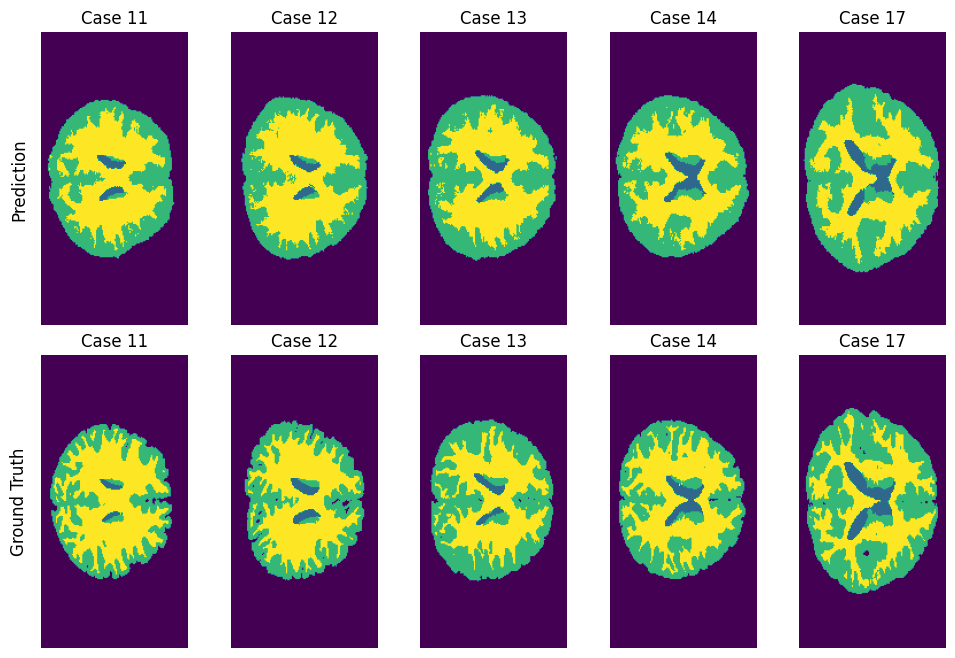

In [55]:
n_slice = 150

val_cases_orig_unique = df.loc[df['Fixed Type'] == "val"]['Fixed Image'].unique()

print( f"Validation cases: {val_cases_orig_unique}")

val_cases_orig = [11, 12, 13, 14, 17]

# Create subplots with 3 rows and the number of columns based on the number of images
fig, axes = plt.subplots(2, len(val_cases_orig), figsize=(12, 8))

# Add vertical text to indicate original, prediction, and ground truth
axes[0, 0].text(-20, 128, "Prediction", rotation="vertical", va="center", ha="center", fontsize=12)
axes[1, 0].text(-20, 128, "Ground Truth", rotation="vertical", va="center", ha="center", fontsize=12)

# Plot predictions
for i in range(len(val_cases_orig)):
    seg_img = sitk.ReadImage(os.path.join(PROJECT_FOLDER, "atlas", "output", "elastix", "weighted_voting", "val", f"IBSR_{val_cases_orig[i]}_MSE_seg.nii.gz"))
    seg_array = sitk.GetArrayFromImage(seg_img).transpose(2, 1, 0)
    axes[0, i].imshow(seg_array[:, :, n_slice])
    axes[0, i].set_title(f"Case {val_cases_orig[i]}")
    axes[0, i].axis("off")

# Plot ground truth
for i in range(len(val_cases_orig)):
    # Load the validation label using the df dataframe
    validation_label = sitk.GetArrayFromImage(sitk.ReadImage(df.loc[df['Fixed Image'] == val_cases_orig_unique[i]]['Validation Label'].iloc[0])).transpose(2, 1, 0)
    axes[1, i].imshow(validation_label[:, :, n_slice])
    axes[1, i].set_title(f"Case {val_cases_orig[i]}")
    axes[1, i].axis("off")

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Show the plot
plt.show()